# Bayesian inference for ride demand

This notebook applies Bayesian inference to estimate the underlying distribution of ride demand for a selected zone and hour.
Posterior distributions are used to quantify uncertainty in demand.

In [2]:
import pandas as pd
import numpy as np

In [3]:
AGG_PATH = "../../data/processed/nyc_demand_zone_hour_2019_q1.parquet"

# Show all columns
pd.set_option("display.max_columns", None)

# Load aggregated dataset
df = pd.read_parquet(AGG_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1


Restrict the analysis to a single zone and a single hour of day in order to estimate the demand distribution for a specific operational scenario.

In [4]:
# Choose top zone and peak hour
zone_id = 234
hour = 18

subset = df[(df["zone_id"] == zone_id) & (df["hour"] == hour)]
subset.shape

(90, 10)

In [5]:
# The observed demand values represent repeated realizations of zone-hour demand across different days
y = subset["demand"].values

For simplicity, demand is modeled using a normal likelihood. The goal is to demonstrate Bayesian inference for the mean demand.


In [7]:
import pymc as pm

In [8]:
import arviz as az

In [15]:
import pytensor

# Force pure Python linker (no C compilation)
pytensor.config.linker = "py"  
pytensor.config.cxx = ""

In [16]:
with pm.Model() as model:

    mu = pm.Normal("mu", mu=y.mean(), sigma=20)
    sigma = pm.HalfNormal("sigma", sigma=20)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
/Users/adelinapetkova/Documents/git/nyc-urban-demand-intelligence/venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/adelinapetkova/Documents/git/nyc-urban-demand-intelligence/venv/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


A Bayesian normal model is defined for demand with unknown mean and standard deviation. Weakly informative priors are used.

In [17]:
az.summary(trace, var_names=["mu", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,575.303,9.677,557.889,594.311,0.108,0.109,7976.0,5493.0,1.0
sigma,107.584,6.377,95.891,119.913,0.074,0.074,7512.0,5077.0,1.0


array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

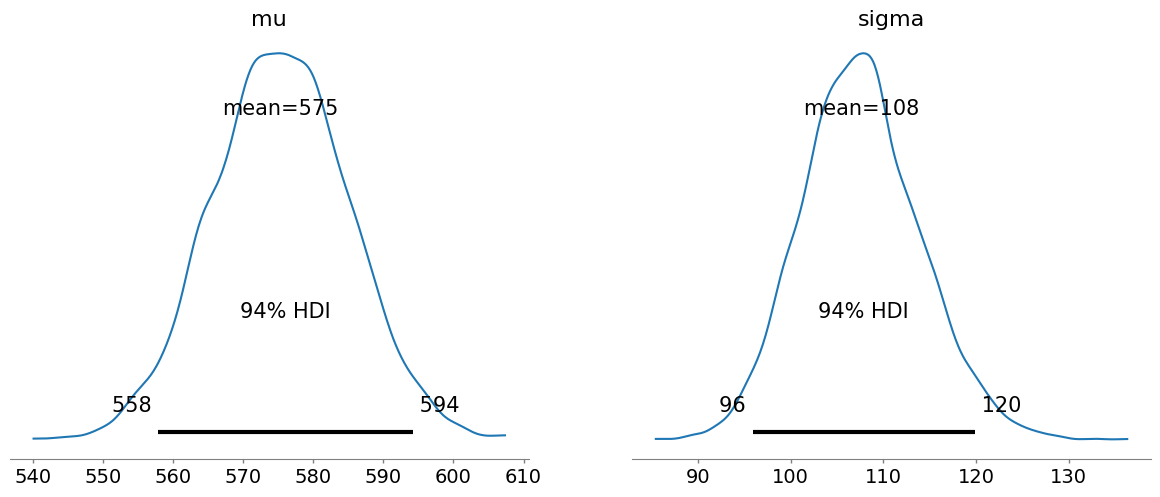

In [18]:
az.plot_posterior(trace, var_names=["mu", "sigma"])

In [20]:
# Compute 95% credible interval
az.hdi(trace, var_names=["mu"], hdi_prob=0.95)

<xarray.Dataset> Size: 64B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    mu       (hdi) float64 16B 557.7 595.9
Attributes:
    created_at:                 2026-02-07T13:10:17.989482+00:00
    arviz_version:              0.23.4
    inference_library:          pymc
    inference_library_version:  5.27.1
    sampling_time:              33.01195693016052
    tuning_steps:               1000

The posterior distribution of the mean demand represents our uncertainty about the typical number of rides for this zone and hour.

Unlike classical confidence intervals, the credible interval directly quantifies the probability that the true mean demand lies within the
reported range.

In [23]:
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

Sampling: [obs]


Output()

In [25]:
ppc_samples = ppc.posterior_predictive["obs"].values
ppc_samples.shape

(4, 2000, 90)

In [26]:
ppc_samples_2d = ppc_samples.reshape(-1, ppc_samples.shape[-1])
ppc_samples_2d.shape

(8000, 90)

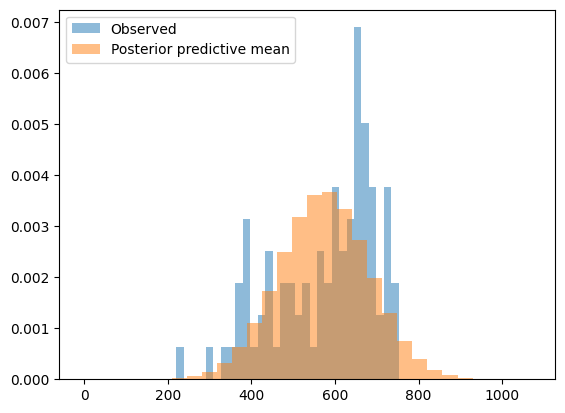

In [31]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30, alpha=0.5, density=True, label="Observed")
plt.hist(ppc_samples_2d.flatten(), bins=30, alpha=0.5, density=True, label="Posterior predictive mean")
plt.legend()
plt.show()

Posterior predictive samples are generated to assess how well the model reproduces the observed demand distribution.

This Bayesian model estimates demand for a fixed zone and hour and does not include explanatory variables such as weather, weekday effects or seasonality.

The normal likelihood is a simplifying assumption. In later stages, count-based models such as Poisson or Negative Binomial will be more appropriate for operational forecasting.